In [1]:
# # Code to convoxel this notebook to .py if you want to run it via command line or with Slurm
# from subprocess import call
# command = "jupyter nbconvoxel train_decoder.ipynb --to python"
# call(command,shell=True)

# Import packages & functions

In [2]:
import os
import sys
import json
import argparse
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom models and functions #
import utils
from models import Clipper, BrainNetwork, BrainDiffusionPrior, VersatileDiffusionPriorNetwork

# Multi-GPU config #
from accelerate import Accelerator
accelerator = Accelerator(split_batches=False,mixed_precision='fp16')  
print("PID of this process =",os.getpid())
print = accelerator.print # only print if local_rank=0
device = accelerator.device
print("device:",device)
num_devices = torch.cuda.device_count()
if num_devices==0: num_devices = 1
num_workers = num_devices
print(accelerator.state)
local_rank = accelerator.state.local_process_index
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size)

PID of this process = 2220106
device: cuda
Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

distributed = False num_devices = 1 local rank = 0 world size = 1


# Configurations

In [3]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    jupyter_args = "--clip_variant=ViT-L/14 --batch_size=32 --n_samples_save=0 --max_lr=3e-4 --mixup_pct=.33 --num_epochs=240 --ckpt_interval=5 --no-use_image_aug --prior_mult=3"
    
    jupyter_args = jupyter_args.split()
    print(jupyter_args)
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    %autoreload 2 # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions

['--clip_variant=ViT-L/14', '--batch_size=32', '--n_samples_save=0', '--max_lr=3e-4', '--mixup_pct=.33', '--num_epochs=240', '--ckpt_interval=5', '--no-use_image_aug', '--prior_mult=3']


In [4]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="name of model, used for ckpt saving and wandb logging",
)
parser.add_argument(
    "--modality", type=str, default="image", choices=["image", "text"],
    help="image or text",
)
parser.add_argument(
    "--data_path", type=str, default="/fsx/proj-medarc/fmri/natural-scenes-dataset",
    help="Path to where NSD data is stored (see README)",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,5,7],
)
parser.add_argument(
    "--voxel2clip_path", type=str, default="None",
    help="pretrained checkpoint to initialize voxel2clip",
)
parser.add_argument(
    "--batch_size", type=int, default=32,
    help="Batch size can be increased by 10x if only training v2c and not diffusion prior",
)
parser.add_argument(
    "--versatile",action=argparse.BooleanOptionalAction,default=True,
    help="if True, CLIP embeddings will come from last hidden layer (e.g., 257x768 - Versatile Diffusion), rather than final layer",
)
parser.add_argument(
    "--clip_variant",type=str,default="ViT-L/14",choices=["RN50", "ViT-L/14", "ViT-B/32", "ViT-H-14", "RN50x64"],
    help='clip / openclip variant',
)
parser.add_argument(
    "--outdir",type=str,default=None,
    help="output directory for logs and checkpoints",
)
parser.add_argument(
    "--wandb_log",action=argparse.BooleanOptionalAction,default=False,
    help="whether to log to wandb",
)
parser.add_argument(
    "--resume_from_ckpt",action=argparse.BooleanOptionalAction,default=False,
    help="if not using wandb and want to resume from a ckpt",
)
parser.add_argument(
    "--wandb_project",type=str,default="stability",
    help="wandb project name",
)
parser.add_argument(
    "--mixup_pct",type=float,default=.33,
    help="proportion of way through training when to switch from InfoNCE to soft_clip_loss",
)
parser.add_argument(
    "--norm_embs",action=argparse.BooleanOptionalAction,default=True,
    help="Do norming (using cls token if VD) of CLIP embeddings",
)
parser.add_argument(
    "--use_image_aug",action=argparse.BooleanOptionalAction,default=False,
    help="whether to use image augmentation (only used for modality=image)",
)
parser.add_argument(
    "--num_epochs",type=int,default=300,
)
parser.add_argument(
    "--prior",action=argparse.BooleanOptionalAction,default=True,
    help="if False, only train via NCE loss",
)
parser.add_argument(
    "--v2c",action=argparse.BooleanOptionalAction,default=True,
    help="if False, only train via diffusion prior loss",
)
parser.add_argument(
    "--plot_umap",action=argparse.BooleanOptionalAction,default=False,
    help="Plot UMAP plots alongside reconstructions",
)
parser.add_argument(
    "--lr_scheduler_type",type=str,default='cycle',choices=['cycle','linear'],
)
parser.add_argument(
    "--ckpt_saving",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--ckpt_interval",type=int,default=5,
    help="save backup ckpt and reconstruct every x epochs",
)
parser.add_argument(
    "--save_at_end",action=argparse.BooleanOptionalAction,default=False,
    help="if True, saves best.ckpt at end of training. if False and ckpt_saving==True, will save best.ckpt whenever epoch shows best validation score",
)
parser.add_argument(
    "--seed",type=int,default=42,
)
parser.add_argument(
    "--max_lr",type=float,default=3e-4,
)
parser.add_argument(
    "--prior_mult",type=float,default=30,
)
parser.add_argument(
    "--n_samples_save",type=int,default=0,
    help="Number of reconstructions for monitoring progress, 0 will speed up training",
)
parser.add_argument(
    "--use_projector",action=argparse.BooleanOptionalAction,default=True,
    help="Additional MLP after the main MLP so model can separately learn a way to minimize NCE from prior loss (BYOL)",
)

if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)
    
# need non-deterministic CuDNN for conv3D to work
utils.seed_everything(seed, cudnn_deterministic=False)

# change learning rate based on number of devices
max_lr *= accelerator.num_processes
    
# change batch size based on number of devices if using multi-gpu
# batch_size *= accelerator.num_processes

# change num_epochs based on number of devices if using multi-gpu
num_epochs *= accelerator.num_processes

Note: not using cudnn.deterministic


In [5]:
if outdir is None:
    outdir = os.path.abspath(f'../train_logs/{model_name}')
if not os.path.exists(outdir):
    os.makedirs(outdir,exist_ok=True)
if use_image_aug:
    import kornia
    from kornia.augmentation.container import AugmentationSequential
    img_augment = AugmentationSequential(
        kornia.augmentation.RandomResizedCrop((224,224), (0.6,1), p=0.3),
        kornia.augmentation.Resize((224, 224)),
        kornia.augmentation.RandomHorizontalFlip(p=0.5),
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1, p=0.3),
        kornia.augmentation.RandomGrayscale(p=0.3),
        data_keys=["input"],
    )
if modality=='text':
    annots = np.load(f"{data_path}/COCO_73k_annots_curated.npy")
    import logging
    logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
    from transformers import CLIPTextModelWithProjection, CLIPTokenizer
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
    text_encoder = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-large-patch14").to(device)
    text_encoder.eval()
    text_encoder.requires_grad_(False)

# Prep models and data loaders

In [6]:
print('Pulling NSD webdataset data...')
# Note: using "voxel" naming even though we use vertices here... makes it easier porting over MindEye lingo

train_url = "/fsx/proj-medarc/fmri/natural-scenes-dataset/algonauts_data/wds/subj01_{2..98}.tar"
val_url = "/fsx/proj-medarc/fmri/natural-scenes-dataset/algonauts_data/wds/subj01_{0..2}.tar"
meta_url = "/fsx/proj-medarc/fmri/natural-scenes-dataset/algonauts_data/wds/metadata_subj01.json"

metadata = json.load(open(meta_url))
num_train = metadata['total'] - 300
num_val = 300

print('Prepping train and validation dataloaders...')
import math
import random
import webdataset as wds
def my_split_by_node(urls):
    return urls

global_batch_size = batch_size * num_devices
num_batches = math.floor(num_train / global_batch_size)
num_worker_batches = math.floor(num_batches / num_workers)

train_data = wds.WebDataset(train_url, resampled=False)\
    .shuffle(500, initial=500, rng=random.Random(seed))\
    .decode("torch")\
    .rename(images="jpg;png", voxels="vert.npy", latent="clip_emb_hidden.npy")\
    .to_tuple("voxels", "images", "latent")\
    .batched(batch_size, partial=False)\
    .with_epoch(num_worker_batches)

train_dl = torch.utils.data.DataLoader(train_data, num_workers=num_workers,
                        batch_size=None, shuffle=False, persistent_workers=True)

global_batch_size = batch_size
num_workers = 1

num_batches = math.ceil(num_val / global_batch_size)
num_worker_batches = math.ceil(num_batches / num_workers)
print("validation: num_worker_batches", num_worker_batches)

val_data = wds.WebDataset(val_url, resampled=False, nodesplitter=my_split_by_node)\
    .decode("torch")\
    .rename(images="jpg;png", voxels="vert.npy", latent="clip_emb_hidden.npy")\
    .to_tuple("voxels", "images", "latent")\
    .batched(batch_size, partial=False)

val_dl = torch.utils.data.DataLoader(val_data, num_workers=num_workers,
                    batch_size=None, shuffle=False, persistent_workers=True)

Pulling NSD webdataset data...
Prepping train and validation dataloaders...
validation: num_worker_batches 10


In [7]:
print('Creating Clipper...')
clip_sizes = {"RN50": 1024, "ViT-L/14": 768, "ViT-B/32": 512, "ViT-H-14": 1024}
clip_size = clip_sizes[clip_variant]
if modality=='image' and clip_variant=="ViT-H-14":
    clip_extractor = OpenClipper(clip_variant, device=device, norm_embs=norm_embs)
    assert versatile==False # versatile diffusion does not accept OpenCLIP ViT-H-14
    out_dim = clip_size
elif modality=='image' and versatile:
    print("Using hidden layer CLIP space (Versatile Diffusion)")
    if not norm_embs:
        print("WARNING: YOU WANT NORMED EMBEDDINGS FOR VERSATILE DIFFUSION!")
    clip_extractor = Clipper(clip_variant, device=device, hidden_state=True, norm_embs=norm_embs)
    out_dim = 257 * clip_size
elif modality=='image':
    print("Using final layer CLIP space (Stable Diffusion Img Variations)")
    if norm_embs:
        print("WARNING: YOU WANT UN-NORMED EMBEDDINGS FOR IMG VARIATIONS!")
    clip_extractor = Clipper(clip_variant, device=device, hidden_state=False, norm_embs=norm_embs)
    out_dim = clip_size
else:
    annots = np.load("/fsx/proj-medarc/fmri/natural-scenes-dataset/COCO_73k_annots_curated.npy")
    out_dim = 77 * clip_size
print("out_dim:",out_dim)

print('Creating voxel2clip...')
if subj == 1:
    num_voxels = 39548
elif subj == 2:
    num_voxels = 99
elif subj == 3:
    num_voxels = 99
elif subj == 4:
    num_voxels = 99
elif subj == 5:
    num_voxels = 99
elif subj == 6:
    num_voxels = 99
elif subj == 7:
    num_voxels = 99
elif subj == 8:
    num_voxels = 99
voxel2clip_kwargs = dict(in_dim=num_voxels,out_dim=out_dim,clip_size=clip_size,use_projector=use_projector)
voxel2clip = BrainNetwork(**voxel2clip_kwargs)
    
# load from ckpt
if voxel2clip_path!="None":
    checkpoint = torch.load(voxel2clip_path, map_location='cpu')
    voxel2clip.load_state_dict(checkpoint['model_state_dict'],strict=False)
    del checkpoint
    
print("params of voxel2clip:")
if local_rank==0:
    utils.count_params(voxel2clip)
    
# setup prior network
out_dim = clip_size
depth = 6
dim_head = 64
heads = clip_size//64 # heads * dim_head = 12 * 64 = 768
guidance_scale = 3.5
timesteps = 100
prior_network = VersatileDiffusionPriorNetwork(
        dim=out_dim,
        depth=depth,
        dim_head=dim_head,
        heads=heads,
        causal=False,
        num_tokens = 257,
        learned_query_mode="pos_emb"
    ).to(device)
print("prior_network loaded")

# custom version that can fix seeds
diffusion_prior = BrainDiffusionPrior(
    net=prior_network,
    image_embed_dim=out_dim,
    condition_on_text_encodings=False,
    timesteps=timesteps,
    cond_drop_prob=0.2,
    image_embed_scale=None,
    voxel2clip=voxel2clip,
).to(device)

if not prior:
    diffusion_prior = diffusion_prior.requires_grad_(False)
    diffusion_prior.voxel2clip.requires_grad_(True)

print("params of diffusion prior:")
if local_rank==0:
    utils.count_params(diffusion_prior)

no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
opt_grouped_parameters = [
    {'params': [p for n, p in diffusion_prior.net.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
    {'params': [p for n, p in diffusion_prior.net.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    {'params': [p for n, p in diffusion_prior.voxel2clip.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
    {'params': [p for n, p in diffusion_prior.voxel2clip.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=max_lr)

global_batch_size = batch_size * num_devices
if lr_scheduler_type == 'linear':
    lr_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        total_iters=int(num_epochs*(num_train//global_batch_size)),
        last_epoch=-1
    )
elif lr_scheduler_type == 'cycle':
    total_steps=int(num_epochs*(num_train//global_batch_size))
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=max_lr,
        total_steps=total_steps,
        final_div_factor=1000,
        last_epoch=-1, pct_start=2/num_epochs
    )
    
def save_ckpt(tag):    
    ckpt_path = outdir+f'/{tag}.pth'
    print(f'saving {ckpt_path}',flush=True)
    unwrapped_model = accelerator.unwrap_model(diffusion_prior)
    try:
        torch.save({
            'epoch': epoch,
            'model_state_dict': unwrapped_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'train_losses': losses,
            'val_losses': val_losses,
            'lrs': lrs,
            }, ckpt_path)
    except:
        print("Couldn't save... moving on to prevent crashing.")
    del unwrapped_model
        
print("\nDone with model preparations!")

Creating Clipper...
Using hidden layer CLIP space (Versatile Diffusion)
ViT-L/14 cuda
out_dim: 197376
Creating voxel2clip...
params of voxel2clip:
param counts:
1,045,163,008 total
1,045,163,008 trainable
prior_network loaded
params of diffusion prior:
param counts:
1,101,218,192 total
1,101,218,176 trainable

Done with model preparations!


# Weights and Biases

In [8]:
# params for wandb
if local_rank==0 and wandb_log: # only use main process for wandb logging
    import wandb
    
    wandb_project = 'stability'
    wandb_run = model_name
    wandb_notes = ''
    
    print(f"wandb {wandb_project} run {wandb_run}")
    wandb.login(host='https://stability.wandb.io')#, relogin=True)
    wandb_config = {
      "model_name": model_name,
      "modality": modality,
      "clip_variant": clip_variant,
      "batch_size": batch_size,
      "num_epochs": num_epochs,
      "use_image_aug": use_image_aug,
      "max_lr": max_lr,
      "lr_scheduler_type": lr_scheduler_type,
      "mixup_pct": mixup_pct,
      "num_train": num_train,
      "num_val": num_val,
      "seed": seed,
      "distributed": distributed,
      "num_devices": num_devices,
      "world_size": world_size,
      "train_url": train_url,
      "val_url": val_url,
    }
    print("wandb_config:\n",wandb_config)
    if True: # wandb_auto_resume
        print("wandb_id:",model_name)
        wandb.init(
            id = model_name,
            project=wandb_project,
            name=wandb_run,
            config=wandb_config,
            notes=wandb_notes,
            resume="allow",
        )
    else:
        wandb.init(
            project=wandb_project,
            name=wandb_run,
            config=wandb_config,
            notes=wandb_notes,
        )
else:
    wandb_log = False

# Main

In [9]:
epoch = 0
losses, val_losses, lrs = [], [], []
nce_losses, val_nce_losses = [], []
sim_losses, val_sim_losses = [], []
best_val_loss = 1e9
soft_loss_temps = utils.cosine_anneal(0.004, 0.0075, num_epochs - int(mixup_pct * num_epochs))
val_voxel0 = val_image0 = None

# Optionally resume from checkpoint #
if resume_from_ckpt:
    print("\n---resuming from last.pth ckpt---\n")
    try:
        checkpoint = torch.load(outdir+'/last.pth', map_location='cpu')
    except:
        print('last.pth failed... trying last_backup.pth')
        checkpoint = torch.load(outdir+'/last_backup.pth', map_location='cpu')
    epoch = checkpoint['epoch']
    print("Epoch",epoch)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    diffusion_prior.load_state_dict(checkpoint['model_state_dict'])
    del checkpoint
elif wandb_log:
    if wandb.run.resumed:
        print("\n---resuming from last.pth ckpt---\n")
        try:
            checkpoint = torch.load(outdir+'/last.pth', map_location='cpu')
        except:
            print('last.pth failed... trying last_backup.pth')
            checkpoint = torch.load(outdir+'/last_backup.pth', map_location='cpu')
        epoch = checkpoint['epoch']
        print("Epoch",epoch)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
        diffusion_prior.load_state_dict(checkpoint['model_state_dict'])
        del checkpoint
torch.cuda.empty_cache()

In [10]:
diffusion_prior, optimizer, train_dl, val_dl, lr_scheduler = accelerator.prepare(
diffusion_prior, optimizer, train_dl, val_dl, lr_scheduler
)

torch.Size([32, 3, 425, 425]) cuda:0
torch.Size([32, 3, 39548])
torch.Size([32, 1, 257, 768])


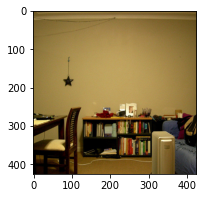

In [11]:
for i, (voxel,image,clip) in enumerate(val_dl):
    print(image.shape,image.device)
    print(voxel.shape)
    print(clip.shape)
    plt.figure(figsize=(3,3))
    plt.imshow(utils.torch_to_Image(image))
    break

In [1]:
print(f"{model_name} starting with epoch {epoch} / {num_epochs}")
progress_bar = tqdm(range(epoch,num_epochs), ncols=1200, disable=(local_rank!=0))

for epoch in progress_bar:
    diffusion_prior.train()

    sims_base = 0.
    val_sims_base = 0.
    fwd_percent_correct = 0.
    bwd_percent_correct = 0.
    val_fwd_percent_correct = 0.
    val_bwd_percent_correct = 0.
    loss_nce_sum = 0.
    loss_prior_sum = 0.
    val_loss_nce_sum = 0.
    val_loss_prior_sum = 0.

    for train_i, (voxel, image, latent) in enumerate(train_dl):
        with torch.cuda.amp.autocast():
            optimizer.zero_grad()
            repeat_index = train_i % 3
            voxel = voxel[:,repeat_index].float()
            
            if use_image_aug:
                image = img_augment(image)
                # plt.imshow(utils.torch_to_Image(image))
                # plt.show()

            if epoch < int(mixup_pct * num_epochs):
                voxel, perm, betas, select = utils.mixco(voxel)

            # clip_target = clip_extractor.embed_image(image).float()
            clip_target = latent.to(device).float().squeeze(1)

            clip_voxels, clip_voxels_proj = diffusion_prior.module.voxel2clip(voxel) if distributed else diffusion_prior.voxel2clip(voxel)
            if versatile:
                clip_voxels = clip_voxels.view(len(voxel),-1,clip_size)
            
            if prior:
                loss_prior, aligned_clip_voxels = diffusion_prior(text_embed=clip_voxels, image_embed=clip_target)
                aligned_clip_voxels /= diffusion_prior.module.image_embed_scale if distributed else diffusion_prior.image_embed_scale
            else:
                aligned_clip_voxels = clip_voxels

            clip_voxels_norm = nn.functional.normalize(clip_voxels_proj.flatten(1), dim=-1)
            clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

            if epoch < int(mixup_pct * num_epochs):
                loss_nce = utils.mixco_nce(
                    clip_voxels_norm,
                    clip_target_norm,
                    temp=.006, 
                    perm=perm, betas=betas, select=select)
            else:
                epoch_temp = soft_loss_temps[epoch-int(mixup_pct*num_epochs)]
                loss_nce = utils.soft_clip_loss(
                    clip_voxels_norm,
                    clip_target_norm,
                    temp=epoch_temp)
                
            if prior and v2c:
                loss_nce_sum += loss_nce.item()
                loss_prior_sum += loss_prior.item()
                loss = loss_nce + (prior_mult * loss_prior)
            elif v2c:
                loss_nce_sum += loss_nce.item()
                loss = loss_nce
            elif prior:
                loss_prior_sum += loss_prior.item()
                loss = prior_mult * loss_prior
            utils.check_loss(loss)
            
            accelerator.backward(loss)
            optimizer.step()

            losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]['lr'])

            # gather batches across multi-gpu if there's multiple
            # clip_voxel_gather = accelerator.gather(clip_voxels_norm.view(len(voxel),-1).contiguous())
            # clip_target_gather = accelerator.gather(clip_target_norm.view(len(voxel),-1).contiguous())

            sims_base += nn.functional.cosine_similarity(clip_target_norm,clip_voxels_norm).mean().item()

            # forward and backward top 1 accuracy        
            labels = torch.arange(len(clip_target_norm)).to(device) 
            fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1)
            bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1)

            if lr_scheduler_type is not None:
                lr_scheduler.step()

    diffusion_prior.eval()
    for val_i, (voxel, image, latent) in enumerate(val_dl): 
        with torch.no_grad():
            with torch.cuda.amp.autocast():
                voxel = torch.mean(voxel,axis=1)
                
                if use_image_aug:
                    image = img_augment(image)

                if val_image0 is None:
                    val_image0 = image.detach().clone()
                    val_voxel0 = voxel.detach().clone()

                # clip_target = clip_extractor.embed_image(image).float()
                clip_target = latent.to(device).float().squeeze(1)

                clip_voxels, clip_voxels_proj = diffusion_prior.module.voxel2clip(voxel) if distributed else diffusion_prior.voxel2clip(voxel)
                if versatile:
                    clip_voxels = clip_voxels.view(len(voxel),-1,clip_size)
                
                if prior:
                    val_loss_prior, aligned_clip_voxels = diffusion_prior(text_embed=clip_voxels, image_embed=clip_target)
                    aligned_clip_voxels /= diffusion_prior.module.image_embed_scale if distributed else diffusion_prior.image_embed_scale
                else:
                    aligned_clip_voxels = clip_voxels

                clip_voxels_norm = nn.functional.normalize(clip_voxels_proj.flatten(1), dim=-1)
                clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

                if epoch < int(mixup_pct * num_epochs):
                    val_loss_nce = utils.mixco_nce(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=.006, 
                        perm=None, betas=None, select=None)
                else:
                    val_loss_nce = utils.soft_clip_loss(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=epoch_temp)

                if prior and v2c:
                    val_loss_nce_sum += val_loss_nce.item()
                    val_loss_prior_sum += val_loss_prior.item()
                    val_loss = val_loss_nce + (prior_mult * val_loss_prior)
                elif v2c:
                    val_loss_nce_sum += val_loss_nce.item()
                    val_loss = val_loss_nce
                elif prior:
                    val_loss_prior_sum += val_loss_prior.item()
                    val_loss = prior_mult * val_loss_prior
                utils.check_loss(val_loss)
                
                val_losses.append(val_loss.item())

                # clip_voxel_gather = accelerator.gather(clip_voxels_norm.view(len(voxel),-1).contiguous())
                # clip_target_gather = accelerator.gather(clip_target_norm.view(len(voxel),-1).contiguous())

                val_sims_base += nn.functional.cosine_similarity(clip_target_norm,clip_voxels_norm).mean().item()
                
                labels = torch.arange(len(clip_target_norm)).to(device)
                val_fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1)
                val_bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1)

    if local_rank==0:        
        if (not save_at_end and ckpt_saving) or (save_at_end and epoch == num_epochs - 1):
            # save best model
            val_loss = np.mean(val_losses[-(val_i+1):])
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                save_ckpt('best')
            else:
                print(f'not best - val_loss: {val_loss:.3f}, best_val_loss: {best_val_loss:.3f}')
                
        if utils.is_interactive():
            clear_output(wait=True)
            
        logs = {"train/loss": np.mean(losses[-(train_i+1):]),
            "val/loss": np.mean(val_losses[-(val_i+1):]),
            "train/lr": lrs[-1],
            "train/num_steps": len(losses),
            "val/num_steps": len(val_losses),
            "train/cosine_sim_base": sims_base / (train_i + 1),
            "val/cosine_sim_base": val_sims_base / (val_i + 1),
            "train/fwd_pct_correct": fwd_percent_correct / (train_i + 1),
            "train/bwd_pct_correct": bwd_percent_correct / (train_i + 1),
            "val/val_fwd_pct_correct": val_fwd_percent_correct / (val_i + 1),
            "val/val_bwd_pct_correct": val_bwd_percent_correct / (val_i + 1),
            "train/loss_nce": loss_nce_sum / (train_i + 1),
            "train/loss_prior": loss_prior_sum / (train_i + 1),
            "val/loss_nce": val_loss_nce_sum / (val_i + 1),
            "val/loss_prior": val_loss_prior_sum / (val_i + 1)}
        progress_bar.set_postfix(**logs)

        # Save model checkpoint and reconstruct
        save_ckpt(f'last')
        if epoch % ckpt_interval == 0:
            save_ckpt(f'last_backup')
                
        if wandb_log: wandb.log(logs)
        
    # wait for other GPUs to catch up if needed
    accelerator.wait_for_everyone()

print("\n===Finished!===\n")
if not utils.is_interactive():
    sys.exit(0)